## open file

[kaggle data link](https://www.kaggle.com/competitions/spaceship-titanic)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import os
folder_path = '/content/drive/MyDrive/'
data_path = os.path.join(folder_path,'kaggle','spaceship-titanic','data')
train = os.path.join(data_path,'train.csv')
test = os.path.join(data_path,'test.csv')
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)
data = [df_train,df_test]

## data prepare

In [6]:
def split_PassengerId(x,n):
  if pd.isna(x):  # 需要考慮空值
    return None
  else:
    return(x.split('_')[n])

def split_cabin(x,n):
  if pd.isna(x):  # 需要考慮空值
    return None
  else:
    return(x.split('/')[n])

def turn_int(x):
  if pd.isna(x):  # 需要考慮空值
    return None
  else:
    return(int(x))

In [7]:
for df in data:
  df['group'] = df['PassengerId'].apply(lambda x: split_PassengerId(x,0))
  df['p_num'] = df['PassengerId'].apply(lambda x: split_PassengerId(x,1))
  df['group_size']=df['group'].map(lambda x: df['group'].value_counts()[x])
  df['Solo']=(df['group_size']==1).astype(int)

  df['deck'] = df['Cabin'].apply(lambda x: split_cabin(x,0))
  df['c_num'] = df['Cabin'].apply(lambda x: split_cabin(x,1))
  df['side'] = df['Cabin'].apply(lambda x: split_cabin(x,2))
  df['c_num'] = df['c_num'].apply(lambda x: turn_int(x))

  exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  df['Expenditure']=df[exp_features].sum(axis=1)     # 花費加總
  df['No_spending']=(df['Expenditure']==0).astype(int)  # 免費仔

## fill null

### info

In [8]:
# print('========== train data null ==========')
# print(round(data[0].isnull().sum()/len(data[0]),2)) # missing values ​​is around 2%
# print('========== test data null ==========')
# print(round(data[1].isnull().sum()/len(data[1]),2))

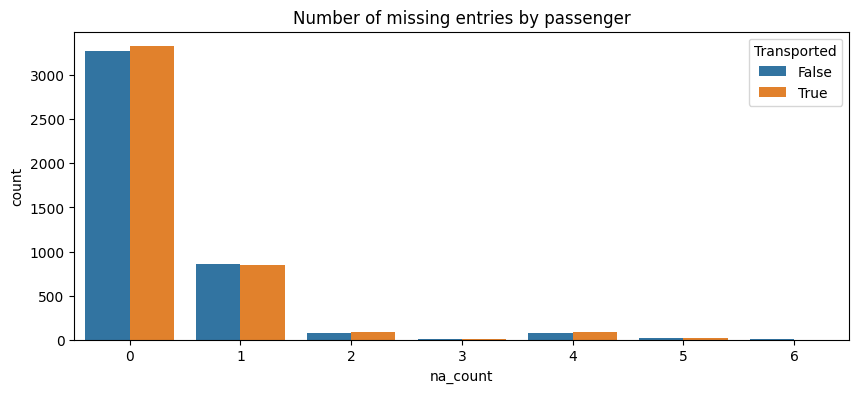

In [9]:
df = data[0]
df['na_count']=df.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
df.drop('na_count', axis=1, inplace=True)

### Homeplanet

In [10]:
for df in data:
  na_before=df['HomePlanet'].isna().sum()
  GHP_gb=df.groupby(['group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
  GHP_index=df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['group']).isin(GHP_gb.index)].index
  df.loc[GHP_index,'HomePlanet']=df.iloc[GHP_index,:]['group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])
  na_after=df['HomePlanet'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 201 to 111
missing values ​​dropped from 87 to 46


In [11]:
df = data[0]
pd.crosstab(df['HomePlanet'], df['deck'])

deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0,0,0,0,400,1620,2518,0
Europa,255,778,743,189,130,0,0,4
Mars,0,0,0,285,335,1130,0,0


In [12]:
for df in data:
  na_before=df['HomePlanet'].isna().sum()
  df.loc[(df['HomePlanet'].isna()) & (df['deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'
  df.loc[(df['HomePlanet'].isna()) & (df['deck']=='G'), 'HomePlanet']='Earth'
  na_after=df['HomePlanet'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 111 to 63
missing values ​​dropped from 46 to 31


In [13]:
df.HomePlanet.value_counts(normalize=True).round(2)

Earth     0.54
Europa    0.24
Mars      0.22
Name: HomePlanet, dtype: float64

In [14]:
for df in data:
  na_before=df['HomePlanet'].isna().sum()
  df.loc[(df['HomePlanet'].isna()),'HomePlanet']=df.HomePlanet.mode()[0]  # earth
  na_after=df['HomePlanet'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 63 to 0
missing values ​​dropped from 31 to 0


### destination

In [15]:
df=data[0]
pd.crosstab(df['Destination'], df['deck'])

deck,A,B,C,D,E,F,G,T
Destination,,,,,,,,
55 Cancri e,108,333,317,113,116,398,365,0
PSO J318.5-22,2,3,13,17,41,241,461,0
TRAPPIST-1e,142,426,405,338,696,2088,1688,5


In [16]:
df.Destination.value_counts(normalize=True).round(2)

TRAPPIST-1e      0.69
55 Cancri e      0.21
PSO J318.5-22    0.09
Name: Destination, dtype: float64

In [17]:
for df in data:
  na_before = df['Destination'].isna().sum()
  mode = df.Destination.mode()[0]
  df['Destination'].fillna(mode,inplace=True)  # TRAPPIST-1e
  na_after = df['Destination'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 182 to 0
missing values ​​dropped from 92 to 0


### Cabin

#### side

In [18]:
for df in data:
  GCD_gb=df[df['group_size']>1].groupby(['group','deck'])['deck'].size().unstack().fillna(0)
  GCN_gb=df[df['group_size']>1].groupby(['group','c_num'])['c_num'].size().unstack().fillna(0)
  GCS_gb=df[df['group_size']>1].groupby(['group','side'])['side'].size().unstack().fillna(0)
  na_before=df['side'].isna().sum()
  GCS_index=df[df['side'].isna()][(df[df['side'].isna()]['group']).isin(GCS_gb.index)].index
  df.loc[GCS_index,'side']=df.iloc[GCS_index,:]['group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])
  na_after=df['side'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 199 to 99
missing values ​​dropped from 100 to 63


In [19]:
df = data[0]
df.side.value_counts(normalize=True).round(2)

S    0.51
P    0.49
Name: side, dtype: float64

In [20]:
for df in data:
  na_before=df['side'].isna().sum()
  min = df.side.value_counts().idxmin()
  df['side'].fillna(min,inplace=True)  # P
  na_after=df['side'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 99 to 0
missing values ​​dropped from 63 to 0


#### deck

In [21]:
for df in data:
  na_before=df['deck'].isna().sum()
  GCD_index=df[df['deck'].isna()][(df[df['deck'].isna()]['group']).isin(GCD_gb.index)].index
  df.loc[GCD_index,'deck']=df.iloc[GCD_index,:]['group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])
  na_after=df['deck'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 199 to 199
missing values ​​dropped from 100 to 63


In [22]:
df.deck.value_counts(normalize=True).round(2)

F    0.35
G    0.29
E    0.11
B    0.09
C    0.09
D    0.06
A    0.02
T    0.00
Name: deck, dtype: float64

In [23]:
for df in data:
  na_before=df['deck'].isna().sum()
  mode = df.deck.mode()[0]
  df['deck'].fillna(mode,inplace=True)
  na_after=df['deck'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 199 to 0
missing values ​​dropped from 63 to 0


#### num

In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

for df in data:
  na_before=df['c_num'].isna().sum()

  for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    X_CN=df.loc[~(df['c_num'].isna()) & (df['deck']==deck),'group']
    y_CN=df.loc[~(df['c_num'].isna()) & (df['deck']==deck),'c_num']
    X_test_CN=df.loc[(df['c_num'].isna()) & (df['deck']==deck),'group']

    if not X_test_CN.empty:
      model_CN=sklearn.linear_model.LinearRegression()
      model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
      preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
      df.loc[(df['c_num'].isna()) & (df['deck']==deck),'c_num']=preds_CN.astype(int)

  na_after=df['c_num'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 199 to 0
missing values ​​dropped from 100 to 0


### age

In [25]:
for df in data:
  na_before=df['Age'].isna().sum()
  median = df.Age.median()
  df['Age'].fillna(median,inplace=True)
  na_after=df['Age'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 179 to 0
missing values ​​dropped from 91 to 0


### cryosleep

In [26]:
pd.crosstab(df['No_spending'], df['CryoSleep'])

CryoSleep,False,True
No_spending,,
0,2418,0
1,222,1544


In [27]:
for df in data:
  na_before=df['CryoSleep'].isna().sum()
  na_rows_CSL=df.loc[df['CryoSleep'].isna(),'CryoSleep'].index
  df.loc[df['CryoSleep'].isna(),'CryoSleep']=df.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]
  na_after=df['CryoSleep'].isna().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 217 to 0
missing values ​​dropped from 93 to 0


In [28]:
df.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,2473.0,0.0
1,222.0,1582.0


### Expenditure

In [29]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in data:
  for col in exp_features:
    df.loc[(df[col].isna()) & (df['CryoSleep']==True), col]=0

In [30]:
import numpy as np
for df in data:
  df['Age_group']=np.nan
  df.loc[df['Age']<=12,'Age_group']='Age_0-12'
  df.loc[(df['Age']>12) & (df['Age']<18),'Age_group']='Age_13-17'
  df.loc[(df['Age']>=18) & (df['Age']<=25),'Age_group']='Age_18-25'
  df.loc[(df['Age']>25) & (df['Age']<=30),'Age_group']='Age_26-30'
  df.loc[(df['Age']>30) & (df['Age']<=50),'Age_group']='Age_31-50'
  df.loc[df['Age']>50,'Age_group']='Age_51+'

In [31]:
df = data[0]
df.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   701.267606   782.542029   781.434783   773.833887   
           1          0.0   634.065574   779.581657   774.315068   814.328554   
Europa     0          0.0  1102.955752  2723.480851  3521.185430  4064.285461   
           1          0.0     0.000000  2396.219512  3720.588889  3978.302703   
Mars       0          0.0  1196.301370  1208.330189  1159.195312  1160.916996   
           1          0.0  1914.157895  1171.940171  1006.305085  1154.914040   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      811.919540  
           1      794.228448  
Europa     0     3507.621951  
           1     3804.560748  
Mars       0     1139.774648  
           1     1117.828947

In [32]:
for df in data:
  df.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)
  na_before=df[exp_features].isna().sum().sum()
  for col in exp_features:
    na_rows=df.loc[df[col].isna(),col].index   # transform專門用在groupby的後面，除此之外和apply類似。
    df.loc[df[col].isna(),col]=df.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
  na_after=df[exp_features].isna().sum().sum()
  print(f'missing values ​​dropped from {na_before} to {na_after}')

missing values ​​dropped from 571 to 0
missing values ​​dropped from 295 to 0


### VIP

98% no VIP

In [33]:
# pd.crosstab(df['VIP'], df['side'])
# df.VIP.value_counts(normalize=True).round(2)

In [34]:
for df in data:
  df.loc[df['VIP'].isna(),'VIP']=False

## check null

In [35]:
for df in data:
  isnull = df.isnull().sum()
  print(isnull[isnull>0])

Cabin    199
Name     200
dtype: int64
Cabin    100
Name      94
dtype: int64


## ending

In [36]:
# df = data[0]
# df.dtypes

In [37]:
n=0
for df in data:
  df['group'] = df['group'].astype(int)
  df['p_num'] = df['p_num'].astype(int)
  df['VIP'] = df['VIP'].astype(int)
  df['CryoSleep'] = df['CryoSleep'].astype(int)
  # df['Transported'] = df['Transported'].astype(int)

  HomePlanet = pd.get_dummies(df['HomePlanet'], prefix='HomePlanet').iloc[:, :-1]
  deck = pd.get_dummies(df['deck'], prefix='deck').iloc[:, :-1]
  side = pd.get_dummies(df['side'], prefix='side').iloc[:, :-1]
  Destination = pd.get_dummies(df['Destination'], prefix='Destination').iloc[:, :-1]
  df = pd.concat([df, HomePlanet, deck, side, Destination], axis=1)

  drop_feature = ['Cabin','Name','Age_group','Expenditure','HomePlanet','deck','side','Destination']
  df.drop(columns=drop_feature, inplace=True)
  data[n] = df
  n=n+1

In [38]:
folder_path = '/content/drive/MyDrive/'
data_path = os.path.join(folder_path,'kaggle','spaceship-titanic','data')
data[0].to_csv(os.path.join(data_path,'finish_train.csv'),index=False)
data[1].to_csv(os.path.join(data_path,'finish_test.csv'),index=False)